# Optimizer Example
Jena Climate ANN example showing comparsion between Adam and *newer* optimizers.
This is a regression model, using 3-hour data.

Richard Henry, 18-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.16.2'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

|Dataset|Architecture|Group|Type|
|---|---|---|---|
|Jena3|ANN|Modern|Regression|

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 2.09 s
Wall time: 2.23 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model functions
def model_core():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64,
                                  activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32,
                                  activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1,
                                  activation='linear')
        ]
    )
    return model
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model=model_core()
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    # Reduce variation in training...
    tf.random.set_seed(17)
    print("History Match:")
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    print("\n")
    print("Evaluate Model:")
    myEva=model.evaluate(xTrain,
                         y_train,
                         batch_size=bat_len)
    print("All Sample MSE:",myEva[0])
    print("All Sample MAE:",myEva[1])
    print("\n")
    print("Make Predictions:")
    myPre=model.predict(xTrain)
    print("\n")
    print("Timing:")
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build('adam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 67.7268 - mean_absolute_error: 6.3581 - val_loss: 21.5253 - val_mean_absolute_error: 3.7191
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.2672 - mean_absolute_error: 3.6958 - val_loss: 15.6930 - val_mean_absolute_error: 3.1316
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.2185 - mean_absolute_error: 3.3449 - val_loss: 13.8489 - val_mean_absolute_error: 2.9311
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.3504 - mean_absolute_error: 3.1623 - val_loss: 13.6267 - val_mean_absolute_error: 2.8991
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.8470 - mean_absolute_error: 3.0099 - val_loss: 13.4064 - val_mean_absolute_error: 2.8536
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.8885 - mean_absolute_error: 2.9191 - val_loss: 13.1789 - val_mean_absolute_error: 2.8360
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.3052 - mean_absolute_err

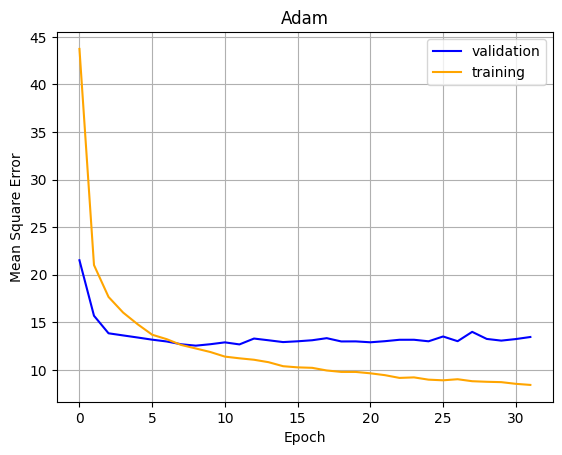

In [13]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h0.history['loss'], color='orange')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam')
plt.grid()
plt.show()

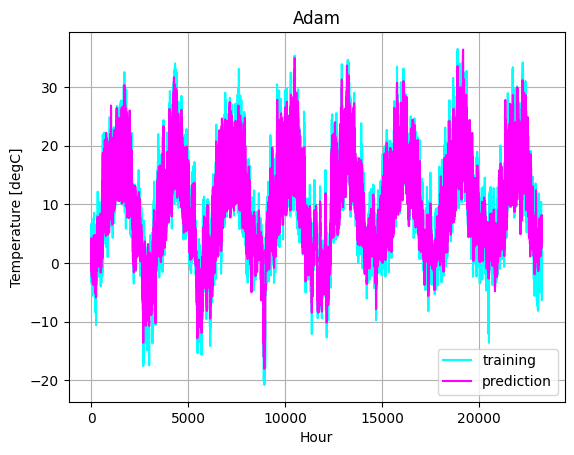

In [14]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam')
plt.grid()
plt.show()

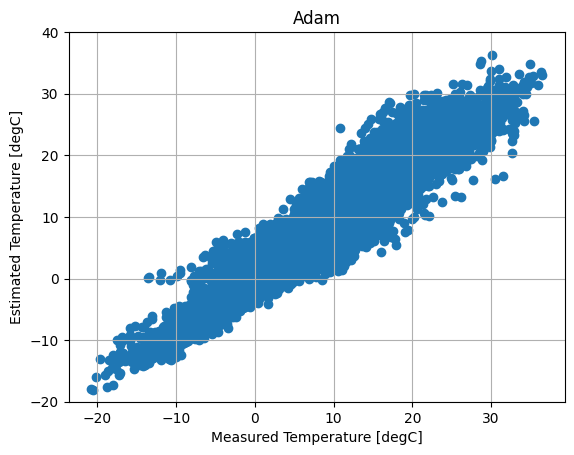

In [15]:
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam')
plt.grid()
plt.ylim([-20,40])
plt.show()

### Second Model, Adam with Weight Decay

In [16]:
%%time
h1,p1=model_build('adamw')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 86.6967 - mean_absolute_error: 7.3046 - val_loss: 23.4468 - val_mean_absolute_error: 3.9017
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.0935 - mean_absolute_error: 3.8462 - val_loss: 15.7890 - val_mean_absolute_error: 3.1801
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.2097 - mean_absolute_error: 3.4217 - val_loss: 14.5520 - val_mean_absolute_error: 3.0458
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8344 - mean_absolute_error: 3.2335 - val_loss: 14.0808 - val_mean_absolute_error: 2.9753
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.6898 - mean_absolute_error: 3.0900 - val_loss: 13.5417 - val_mean_absolute_error: 2.9093
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.4820 - mean_absolute_error: 2.9816 - val_loss: 13.2982 - val_mean_absolute_error: 2.8621
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.1775 - mean_absolute_err

### Third Model, AdaFactor

In [17]:
%%time
h2,p2=model_build('adafactor')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 142.0524 - mean_absolute_error: 9.8848 - val_loss: 144.6413 - val_mean_absolute_error: 10.0388
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 104.4054 - mean_absolute_error: 8.3742 - val_loss: 108.2660 - val_mean_absolute_error: 8.5911
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.5725 - mean_absolute_error: 6.7512 - val_loss: 75.2100 - val_mean_absolute_error: 7.0272
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45.7458 - mean_absolute_error: 5.3292 - val_loss: 51.1833 - val_mean_absolute_error: 5.6712
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34.8008 - mean_absolute_error: 4.6340 - val_loss: 38.1842 - val_mean_absolute_error: 4.8902
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.3372 - mean_absolute_error: 4.3434 - val_loss: 31.2099 - val_mean_absolute_error: 4.4344
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.6817 - mean_absolut

### 4th Model, LION

In [18]:
%%time
h3,p3=model_build('lion')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 66.8821 - mean_absolute_error: 6.3022 - val_loss: 18.9385 - val_mean_absolute_error: 3.4811
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.9696 - mean_absolute_error: 3.6981 - val_loss: 15.7461 - val_mean_absolute_error: 3.1169
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.6564 - mean_absolute_error: 3.4536 - val_loss: 15.7472 - val_mean_absolute_error: 3.1183
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.4042 - mean_absolute_error: 3.2603 - val_loss: 14.6717 - val_mean_absolute_error: 3.0118
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.7890 - mean_absolute_error: 3.1036 - val_loss: 14.0546 - val_mean_absolute_error: 2.9362
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.7432 - mean_absolute_error: 3.0203 - val_loss: 13.4716 - val_mean_absolute_error: 2.8803
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.9570 - mean_absolute_err

### 5th Model, Adam with Nesterov Momentum

In [19]:
%%time
h4,p4=model_build('nadam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 89.4125 - mean_absolute_error: 7.5026 - val_loss: 22.5171 - val_mean_absolute_error: 3.8009
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.8188 - mean_absolute_error: 3.8358 - val_loss: 16.2741 - val_mean_absolute_error: 3.1965
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1029 - mean_absolute_error: 3.4197 - val_loss: 14.4976 - val_mean_absolute_error: 3.0173
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.9876 - mean_absolute_error: 3.2298 - val_loss: 13.5880 - val_mean_absolute_error: 2.9015
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.2560 - mean_absolute_error: 3.0395 - val_loss: 13.2752 - val_mean_absolute_error: 2.8663
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.6015 - mean_absolute_error: 2.9703 - val_loss: 13.6678 - val_mean_absolute_error: 2.9031
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.5785 - mean_absolute_err

### 6th Model, Follow the Regularized Leader

In [20]:
%%time
h5,p5=model_build('ftrl')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 96.7915 - mean_absolute_error: 7.9454 - val_loss: 74.1441 - val_mean_absolute_error: 7.0521
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.1201 - mean_absolute_error: 5.3901 - val_loss: 57.1127 - val_mean_absolute_error: 6.1405
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 38.9099 - mean_absolute_error: 4.9673 - val_loss: 45.0060 - val_mean_absolute_error: 5.4102
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.9977 - mean_absolute_error: 4.5524 - val_loss: 35.5107 - val_mean_absolute_error: 4.7708
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29.2538 - mean_absolute_error: 4.2821 - val_loss: 29.7256 - val_mean_absolute_error: 4.3585
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.7636 - mean_absolute_error: 4.0056 - val_loss: 24.8527 - val_mean_absolute_error: 3.9739
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.0581 - mean_absolute_err

### 7th Model, AdaMax

In [21]:
%%time
h6,p6=model_build('adamax')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 69.8994 - mean_absolute_error: 6.5363 - val_loss: 26.4686 - val_mean_absolute_error: 4.0498
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.7565 - mean_absolute_error: 3.9409 - val_loss: 19.8212 - val_mean_absolute_error: 3.5828
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.7598 - mean_absolute_error: 3.5855 - val_loss: 17.1205 - val_mean_absolute_error: 3.3224
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.5451 - mean_absolute_error: 3.3833 - val_loss: 15.9352 - val_mean_absolute_error: 3.2154
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1778 - mean_absolute_error: 3.2575 - val_loss: 14.7346 - val_mean_absolute_error: 3.0886
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6030 - mean_absolute_error: 3.1900 - val_loss: 13.9122 - val_mean_absolute_error: 2.9961
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.4317 - mean_absolute_err

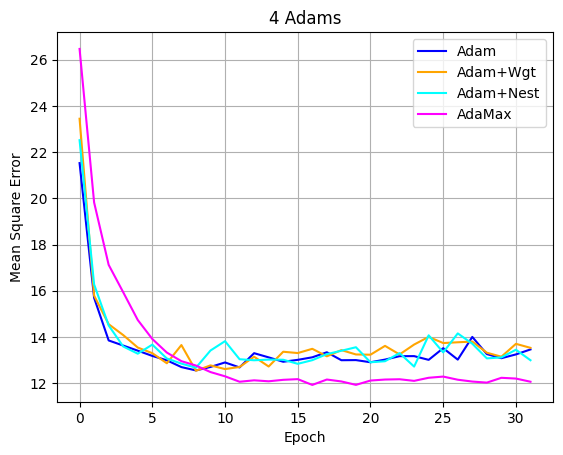

In [22]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange')
plt.plot(h4.history['val_loss'],color='cyan')
plt.plot(h6.history['val_loss'],color='magenta')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','AdaMax'])
plt.title('4 Adams')
plt.grid()
plt.show()

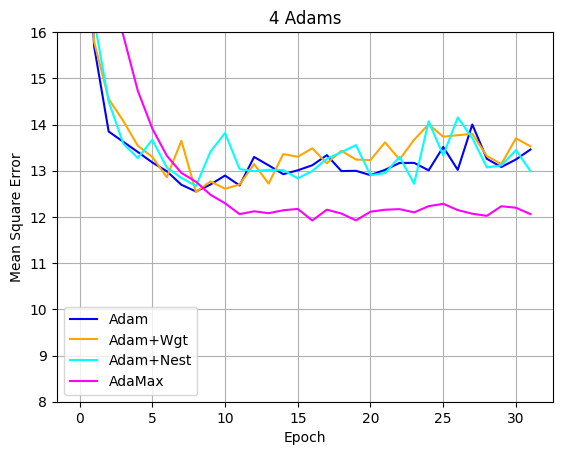

In [23]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange')
plt.plot(h4.history['val_loss'],color='cyan')
plt.plot(h6.history['val_loss'],color='magenta')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','AdaMax'])
plt.title('4 Adams')
plt.ylim([8,16])
plt.grid()
plt.show()

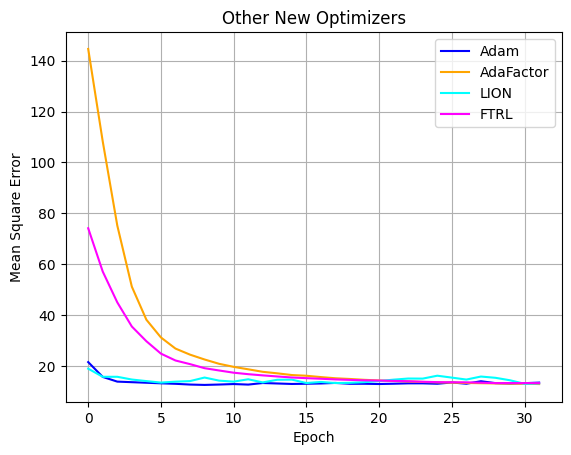

In [24]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h2.history['val_loss'],color='orange')
plt.plot(h3.history['val_loss'],color='cyan')
plt.plot(h5.history['val_loss'],color='magenta')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaFactor','LION','FTRL'])
plt.title('Other New Optimizers')
plt.grid()
plt.show()

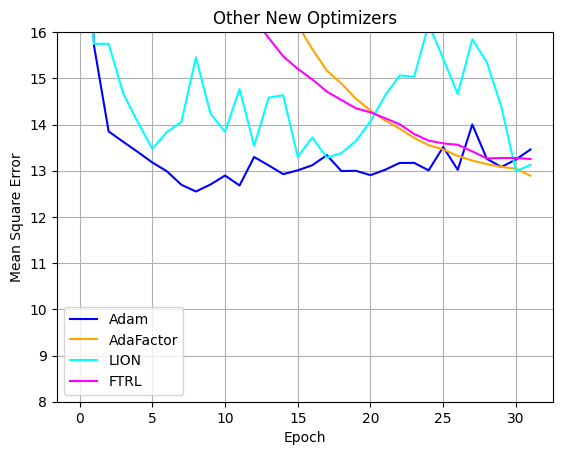

In [26]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h2.history['val_loss'],color='orange')
plt.plot(h3.history['val_loss'],color='cyan')
plt.plot(h5.history['val_loss'],color='magenta')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaFactor','LION','FTRL'])
plt.title('Other New Optimizers')
plt.ylim([8,16])
plt.grid()
plt.show()

## Model Summary

In [25]:
m=model_core()
m.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 128, 11)             │              23 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │          90,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,312 (360.60 KB)

 Trainable params: 92,289 (360.50 KB)

 Non-trainable params: 23 (96.00 B)